### Preamble: Dependencies & Configuration


In [120]:
from __future__ import division

In [121]:
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

NumPy and Matplotlib are Python Libraries that are widely used in scientific computing and data visualisation.

In [122]:
from numpy import *

#### Matplotlib

To get decent defaults for `matplotlib`, we need an estimate of the screen DPI (number of dots per inch).
On my (Linux) computer , the command

    $ xrandr | grep -w connected
    eDP1 connected primary 1600x900+0+0 (normal left inverted right x axis y axis) 346mm x 194mm

provides the required data.

In [123]:
width_cm = 34.6
width_inches = width_cm / 2.54
dpi = 1600 / width_inches
dpi

117.45664739884393

In [124]:
from numpy import *

%matplotlib notebook
%config InlineBackend.print_figure_kwargs={'bbox_inches': None}

import matplotlib as mpl
ratio = 16 / 9
width = 7.0 # inches
height = width / ratio
mpl.rcParams["figure.figsize"] = (width, height)
mpl.rcParams['savefig.dpi'] = mpl.rcParams['figure.dpi'] = dpi

from matplotlib.pyplot import *

The `audio` package is a collection of Python modules developped for this course:

  - use `audio.wave` to read/write WAVE files,
    
  - use `audio.bitstream` to read/write binary data.

In [125]:
import audio.wave
from audio.bitstream import BitStream

In [126]:
from IPython.display import Audio, display

-----

# WAVE Lab

## Synthesis of Pure Tones

We denote $\mathrm{A}_4$ the analog audio signal defined by
  $$
  \mathrm{A}_4(t) = \cos (2 \pi \times 440.0  \times t), \; t \in \mathbb{R}.
  $$
It's a pure tone with unit amplitude, frequency $440.0$ Hz, and no phase.

Let $\Delta f$ be the Compact Disc Digital Audio (CDDA) sample rate:
  $$
  \Delta f = 44100 \; \mbox{Hz}.
  $$

Assign values to the Python variables `df` and `dt` that we use respectively to denote the CDDA sampling rate in hertz and the CDDA sampling period in seconds.
     

Create the increasing NumPy array `t` of the all times in $[0, 3.0)$ that are multiples of $\Delta t$. 
Define the array `A4` of sampled values of $\mathrm{A}_4$ at these times.
 
 

 Plot two periods of this sampled signal against the time.

*the signal $\mathrm{A}_4(t)$ sampled at $44.1$ kHz.*     
     

Save the sampled signal `A4` as a WAVE file named `"A4.wav"` and play it.  
  

Automate and generalize: the name "$\mathrm{A}_4$" comes from the [scientific pitch notation][spn], 
a convention that defines the frequency of symbols that are made of a letter followed by a number identifying the pitch octave. 
The following table displays such frequencies for the letter "A":

         Symbol         $f$ (Hz)
     ----------------- ---------
     $\mathrm{A}_0$         27.5
     $\mathrm{A}_1$         55.0
     $\mathrm{A}_2$        110.0
     $\mathrm{A}_3$        220.0
     $\mathrm{A}_4$        440.0
     $\mathrm{A}_5$        880.0
        ...                  ...
     $\mathrm{A}_{9}$    14080.0
     $\mathrm{A}_{10}$   28160.0
     
[spn]: http://en.wikipedia.org/wiki/Scientific_pitch_notation

Implement a function `make_tone` that given such a `symbol` argument: 

  - returns the values of a 3-sec. audio sample,

  - creates a WAVE file whose name is `symbol + ".wav"`.



In [127]:
df = 44100.0
dt = 1.0 / df
f = 440.0
T = 3.0

In [128]:
t = r_[0.0:T:dt] # see also: arange, linspace, etc.
t[-1] # the last value (T) is excluded

2.9999773242630385

<IPython.core.display.Javascript object>


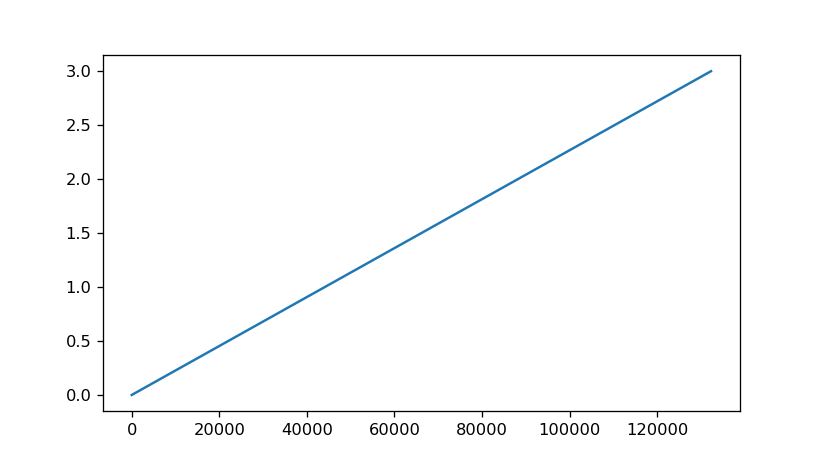

In [129]:
fig, axes = subplots()
_ = axes.plot(t)

In [130]:
A4 = sin(2*pi*f*t)

<IPython.core.display.Javascript object>


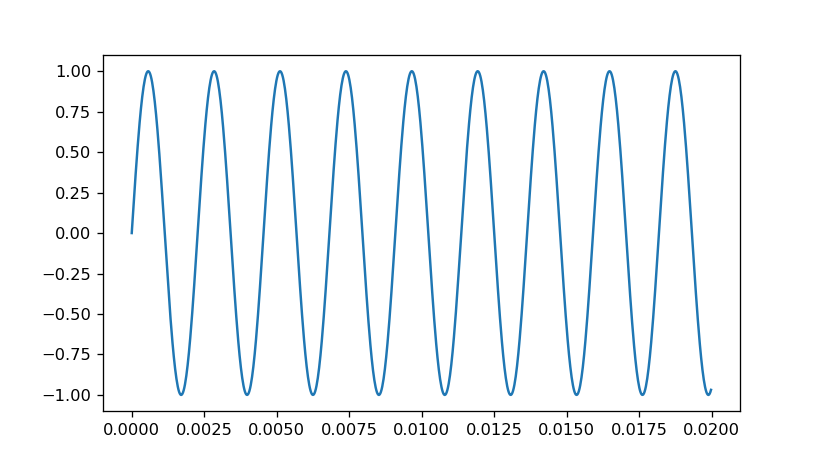

In [131]:
ts = t[t<20.0/1000.0] # 20 ms 
A4s = A4[t<20.0/1000.0]
fig, axes = subplots()
_ = axes.plot(ts, A4s)

In [132]:
def make_tone(symbol):
    number = int(symbol[1:])
    f = 27.5 * 2 ** number
    x = cos(2*pi*f*t)
    audio.wave.write(x, symbol + ".wav")
    return x

In [133]:
A4 = make_tone("A4")

In [134]:
Audio("A4.wav")

In [135]:
A = []
for i in range(0, 11):
    symbol = "A" + str(i)
    A.append(make_tone(symbol))

In [136]:
for i, sound in enumerate(A):
    name = "A" + str(i)
    display(Audio(name + ".wav"))

In [137]:
27.5 * 2**10

28160.0

In [138]:
Audio("A10.wav")

In [139]:
for sound in A:
    print mean(sound*sound)

0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


In [140]:
def L(x):
    return 96.0 + 10.0 * log10(mean(x*x))

In [141]:
L(A[4])

92.989700043360187

## WAVE Format Header Analysis

The WAVEform audio file format – or WAVE for brevity – is a Microsoft and IBM digital audio file format. 
It is a subset of Microsoft’s Resource Interchange File Format (RIFF) specification for multimedia file. 
The WAVE format supports several types of compressions, but we will deal only with the uncompressed
format (also referred to as 16-bit linear PCM, for “Pulse Code Modulation”).

This "canonical" WAVE format is described here: <http://soundfile.sapp.org/doc/WaveFormat/>

In [142]:
raw = open("A4.wav").read() # raw is a 'str' (string)
print raw[:4], raw[8:12]


RIFF WAVE


In [143]:
raw = open("A4.wav").read()
stream = BitStream(raw)
print stream.read(str, 4)
_ = stream.read(str, 4)
print stream.read(str, 4)

RIFF
WAVE


In [144]:
raw = open("A4.wav").read()
stream = BitStream(raw)
_ = stream.read(str, 22)
print stream.read(uint16).newbyteorder() # 2-byte integer (little end.)
print stream.read(uint32).newbyteorder() # 4-byte integer (little end.)

1
44100


In [145]:
def wave_info(filename):
    """
    Get the number of channels and sample rate of a WAVE file.
    """
    raw = open(filename).read()
    header = audio.bitstream.BitStream()
    header.write(raw[:44])
    riff_magic = header.read(str, 4)
    header.read(str, 4)
    wave_magic = header.read(str, 4)
    if riff_magic != "RIFF" or wave_magic != "WAVE":
        raise ValueError("invalid WAVE file {0!r}".format(filename))
    header.read(str, 10)
    info = {}
    info["num_channels"] = header.read(np.uint16).newbyteorder()
    info["sample_rate"]  = header.read(np.uint32).newbyteorder()
    return info

def is_wave(filename):
    """
    Check if `filename` refers to a WAVE file.
    """
    try:
        _ = wave_info(filename)
        return True
    except ValueError:
        return False

## Quantization and Signal-to-Noise Ratio

  1. Load the data of the audio file `"A4.wav"` as an array of floats in
     the $[-1.0, 1.0]$ range named `A4_wav`.

  2. Compute the *quantization error* -- or *quantization noise* -- `e`, defined 
     as the difference between `A4_wav` and the original array `A4`.

  3. Compute the quantization *signal-to-noise ratio* (SNR) in decibels:

       $$
       \mathrm{SNR} \; \mathrm{[dB]} = 10 \log_{10} \mathrm{SNR}^2
       \; \mbox{ where } \;
       \mathrm{SNR}^2 = \frac{\left< \mathtt{A4}^2 \right>}{\left< \mathtt{e}^2 \right>}
       $$


In [146]:
A4q = audio.wave.read("A4.wav")
e = A4 - A4q
SNR = sqrt(mean(A4*A4) / mean(e * e))
print SNR

77863.1828913


In [147]:
print 20.0 * log10(SNR) # SNR in dB

97.8266430567


## Fading: Frames and Windows


The tones that we have generated so far do not start or end smoothly
and the transition from one tone to another is not smooth either.
Such fade in, fade out and cross-fading may be implemented with windows.

Extend the `make_tone` function so that it takes an optional argument `window`, 
a window factory : a function, that takes a length argument 
and returns a window of this length. 

A *window* is a one-dimensional array that is meant to be multiplied element-wise to the original signal.

Search the web for the definition of [classic windows][windows]. 

[windows]: http://docs.scipy.org/doc/numpy/reference/routines.window.html

<IPython.core.display.Javascript object>


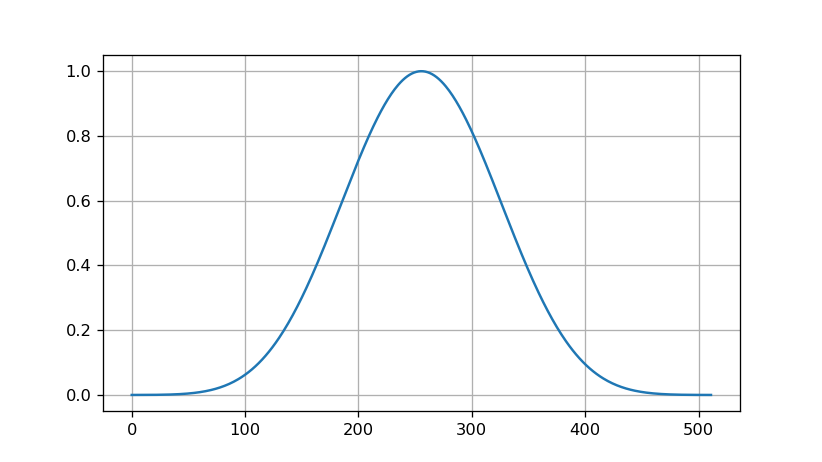

In [148]:
n = 512

# window = ones(n) # rectangular window
# window = bartlett(n) 
# window = blackman(n)
# window = hamming(n)
# window = hanning(n)
window = kaiser(n, beta=14.0)

fig, axes = subplots()
_ = axes.plot(window)
axes.grid()

<IPython.core.display.Javascript object>


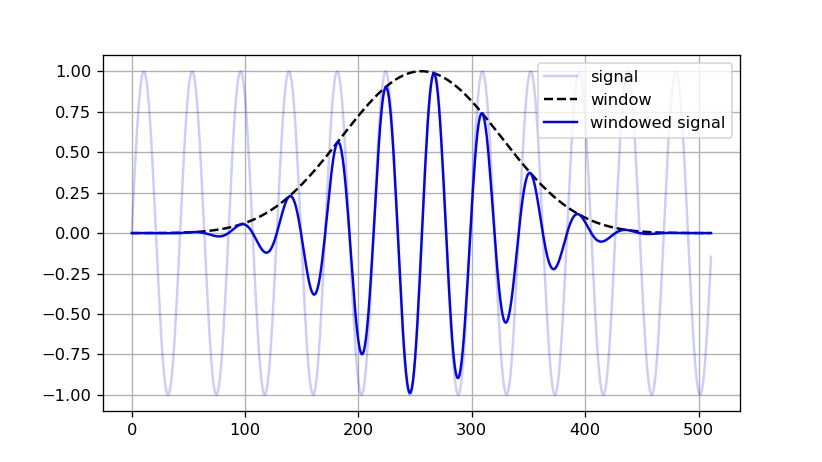

In [149]:
fig, axes = subplots()

periods = 12
x = sin(2 * pi * r_[0:periods:periods/n])

axes.plot(x, "b", alpha=0.2, label="signal")
axes.plot(window, "k--", label="window")
axes.plot(x * window, "b", label="windowed signal")
axes.grid()
axes.legend()

We can for example apply the Hanning window to the pure tone `A4` and listen to the result.

In [150]:
sound = hanning(len(A4)) * A4
audio.wave.write(sound, "A4-hanning.wav")
Audio("A4-hanning.wav")

Consider the signals `A0` to `A10`. 
Create a single "blended" (crossfaded) signal that merges windowed versions of these signals in sequence, with a 1.5 sec (50%) overlap between successive signals.

What if the successive signals are actually *frames* extracted from a common signal ? 
When does the merge between the frames reconstruct exactly the original signal ? 
This condition is referred to as Constant-OverLap-Add (or COLA). 

In [151]:
def display_cross_fading(window):
    n = 512
    window_1 = r_[window(n), zeros(n//2)]
    window_2 = r_[zeros(n//2), window(N)]
    fig, axes = subplots()
    axes.plot(window_1,"k--", alpha=0.5)
    axes.plot(window_2,"k--", alpha=0.5)
    axes.plot(window_1 + window_2, "k")
    axes.grid()

The standard Hanning window satisfies only roughly this condition: 
if you zoom on the flat part of the graph you will see that the sum of two consecutive windows differs up to ~0.3%.
 

<IPython.core.display.Javascript object>


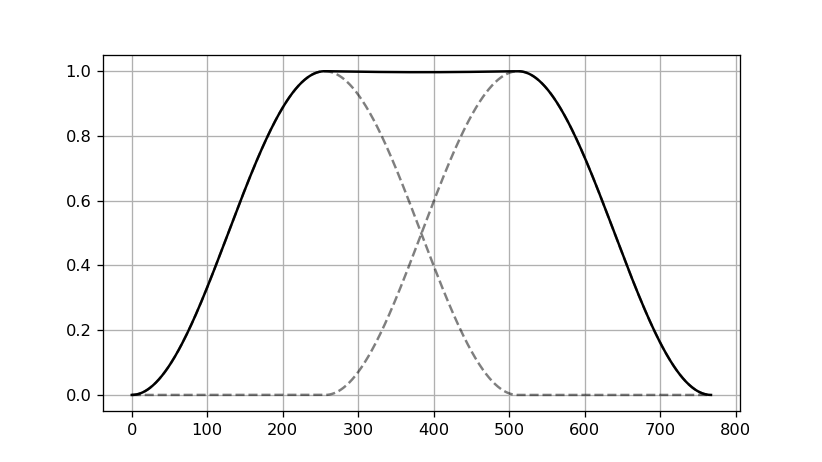

In [152]:
display_cross_fading(window=hanning)

Now on the other hand, we can define the window (factory) `hanning2` that given a length `n` returns the first `n` values of the `hanning`window of length `n + 1`. 
 

In [153]:
def hanning2(n):
    return hanning(n+1)[:-1]

This window satifies the COLA condition with a much higher precision.   

<IPython.core.display.Javascript object>


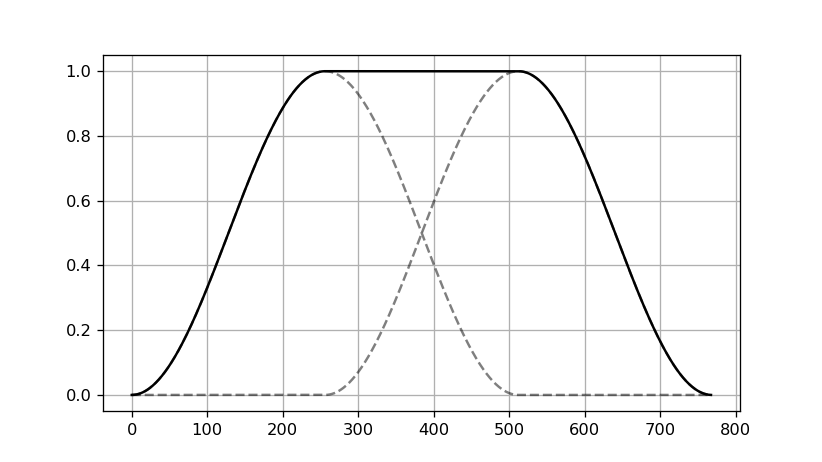

In [154]:
display_cross_fading(hanning2)

In [155]:
window = ones
# window = hanning2

m = len(A)    # number of fragments
n = len(A[0]) # common fragment length
assert n % 2 == 0
output = np.zeros((m + 1) * (n // 2))
for i, A_i in enumerate(A):
    offset = i * (n // 2)
    output[offset:offset + n] += A_i * window(n)
audio.wave.write(output, "A-cross-fading.wav")
Audio("A-cross-fading.wav")

## Misc. (to be sorted)

In [156]:
def SPL(x, dB=True):
    """
    Sound Pressure Level (SPL) in dB
    """
    x = np.array(x, copy=False)
    P = np.mean(x * x)
    if dB:
        return 96.0 + 10 * np.log10(P)
    else:
        return P

def SNR(symbol, dB=True):
    """
    Signal-to-noise ratio of the WAVE quantizer for the tone `symbol`. 
    """
    x = make_tone(symbol, file=True)
    y = audio.wave.read(symbol + ".wav")[0]
    e = y - x
    SNR_2 = sum(x * x) / sum(e * e)
    if dB:
        return 10 * np.log10(SNR_2)
    else:
        return np.sqrt(SNR_2)

def is_COLA(window):
    N = 512
    x = r_[window(N), zeros(N//2)] + r_[zeros(N//2), window(N)]
    return max(abs(x[N//2:-N//2] - 1.0)) < 10 * finfo(float).eps

def make_tone_sequence(crossfading=False):
    octaves = arange(11)
    tones = [make_tone("A" + str(i)) for i in octaves]
    n = len(tones[0])
    if crossfading:
        windowed_tones = [hanning2(n) * tone for tone in tones]
        sound = audio.frames.merge(windowed_tones, overlap=n//2)
        audio.wave.write(sound, "A0-10-crossfading.wav")
    else:
        sound = audio.frames.merge(tones)
        audio.wave.write(sound, "A0-10.wav")
